In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load and preprocess the dataset

* I used EuroSAT dataset from TensorFlow datasets.  
* EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting of 10 classes with 27000 labeled and geo-referenced samples. Shape of image is 64*64*3.  
* Since I have datasets with 27000 observations, I used 80% of datasets as training set, 10% as validation and 10% as test, respecively.  
* After I splited the dataset, I normalized the data to prepare for the model.

In [3]:
#Download and load the training dataset
#ds_train = training set
#ds_info = Dataset metadata
ds_train, ds_info = tfds.load(
    'eurosat',
    split='train[:80%]', #Split 80% of the data into training set 
    shuffle_files=False, #Do not shuffle the data
    as_supervised=True, #Return tuple(img, label)
    with_info=True, #Access the dataset metadata
)

In [4]:
#Download and load the training dataset
#ds_train = training set
#ds_info = Dataset metadata
ds_val, ds_info_val = tfds.load(
    'eurosat',
    split='train[80%:90%]', #Split 10% of the data into training set 
    shuffle_files=False, #Do not shuffle the data
    as_supervised=True, #Return tuple(img, label)
    with_info=True, #Access the dataset metadata
)

In [5]:
#Load the training dataset
#ds_test = test set
#ds_info_test = Dataset metadata
ds_test, ds_info_test = tfds.load(
    'eurosat',
    split='train[90%:]', #Split 10% of the data into training set 
    shuffle_files=False, #Do not shuffle the data
    as_supervised=True, #Return tuple(img, label)
    with_info=True, #Access the dataset metadata
)

In [6]:
#Data metadata
print(ds_info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='C:\\Users\\cy44l\\tensorflow_datasets\\eurosat\\rgb\\2.0.0',
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_

In [7]:
#Size of dataset
print("Size of total dataset: ",ds_info.splits['train'].num_examples)
print("Size of training set: ",ds_info.splits['train[:80%]'].num_examples)
print("Size of validation set: ",ds_info_val.splits['train[80%:90%]'].num_examples)
print("Size of test set: ",ds_info_test.splits['train[90%:]'].num_examples)

Size of total dataset:  27000
Size of training set:  21600
Size of validation set:  2700
Size of test set:  2700


In [8]:
print("train X shape: ", ds_info.features['image'].shape)
print("train y shape: ",ds_info.features['label'].shape)
print("validation X shape: ", ds_info_val.features['image'].shape)
print("validation y shape: ",ds_info_val.features['label'].shape)
print("test X shape: ", ds_info_test.features['image'].shape)
print("test y shape: ",ds_info_test.features['label'].shape)

train X shape:  (64, 64, 3)
train y shape:  ()
validation X shape:  (64, 64, 3)
validation y shape:  ()
test X shape:  (64, 64, 3)
test y shape:  ()


Number of y values:  10
Labels of y values:  ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


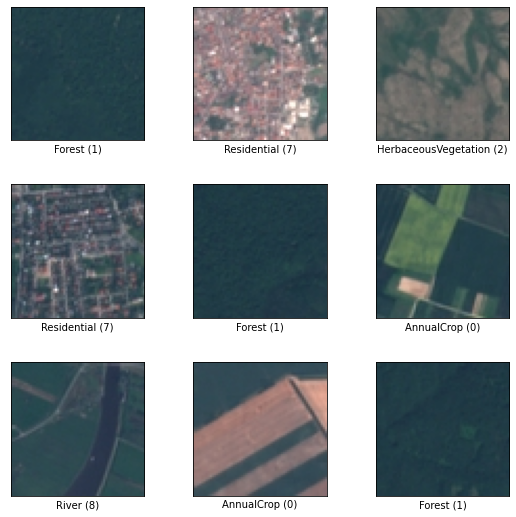

In [9]:
print("Number of y values: ",ds_info.features["label"].num_classes)
print("Labels of y values: ", ds_info.features["label"].names)
fig = tfds.show_examples(ds_train, ds_info)

In [10]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE) #Normalize images
ds_train = ds_train.cache() #Cache before shuffling for better performance
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) #For true randomness, set the shuffle buffer to the full dataset size.
ds_train = ds_train.batch(128) #Batch after shuffling to get unique batches at each epoch.
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE) #Good practice to end the pipeline by prefetching for performances.

In [11]:
ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(128)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## 2. CNN neural network classifier

## 1) Fit training set

In [13]:
#Reference Model
CNN_model_0 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_0.summary()

#Complie
CNN_model_0.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_0_history = CNN_model_0.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1843264   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 25s 138ms/step - loss: 1.7364 - sparse_categorical_accuracy

### c. The training performance for a total of ten different models (with different number of hidden layers and/or different number of hidden units).

In [136]:
#Model1
CNN_model_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_1.summary()

#Complie
CNN_model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_1_history = CNN_model_1.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_64 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_180 (Dense)            (None, 128)               3686528   
_________________________________________________________________
dense_181 (Dense)            (None, 10)                1290      
Total params: 3,688,042
Trainable params: 3,688,042
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 29s 173ms/step - loss: 1.5299 - sparse_categorical_accur

In [15]:
#Model2
CNN_model_2 = Sequential([
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_2.summary()

#Complie
CNN_model_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_2_history = CNN_model_2.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 4)         304       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               921856    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 19s 108ms/step - loss: 1.7355 - sparse_categorical_accuracy: 

In [16]:
#Model3
CNN_model_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_3.summary()

#Complie
CNN_model_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_3_history = CNN_model_3.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3686528   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 3,695,658
Trainable params: 3,695,658
Non-trainable params: 0
____________________________________________

In [17]:
#Model4
CNN_model_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_4.summary()

#Complie
CNN_model_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_4_history = CNN_model_4.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               7373056   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 7,390,378
Trainable params: 7,390,378
Non-trainable params: 0
____________________________________________

In [18]:
#Model5
CNN_model_5 = Sequential([
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_5.summary()

#Complie
CNN_model_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_5_history = CNN_model_5.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 60, 60, 4)         304       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 4)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               460928    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 470,138
Trainable params: 470,138
Non-trainable params: 0
________________________________________________

In [19]:
#Model6
CNN_model_6 = Sequential([
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_6.summary()

#Complie
CNN_model_6.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_6_history = CNN_model_6.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 60, 60, 4)         304       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 4)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               921856    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
Total params: 939,258
Trainable params: 939,258
Non-trainable params: 0
________________________________________________

In [20]:
#Model7
CNN_model_7 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_7.summary()

#Complie
CNN_model_7.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_7_history = CNN_model_7.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_19 (Dense)             (None, 64)               

In [21]:
#Model8
CNN_model_8 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_8.summary()

#Complie
CNN_model_8.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_8_history = CNN_model_8.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

In [22]:
#Model9
CNN_model_9 = Sequential([
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_9.summary()

#Complie
CNN_model_9.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_9_history = CNN_model_9.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 60, 60, 4)         304       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 4)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 4)         404       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 4)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 676)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               86656     
_________________________________________________________________
dense_25 (Dense)             (None, 64)               

In [23]:
#Model10
CNN_model_10 = Sequential([
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_10.summary()

#Complie
CNN_model_10.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_10_history = CNN_model_10.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 60, 60, 4)         304       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 4)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 4)         404       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 4)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 676)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               173312    
_________________________________________________________________
dense_28 (Dense)             (None, 64)              

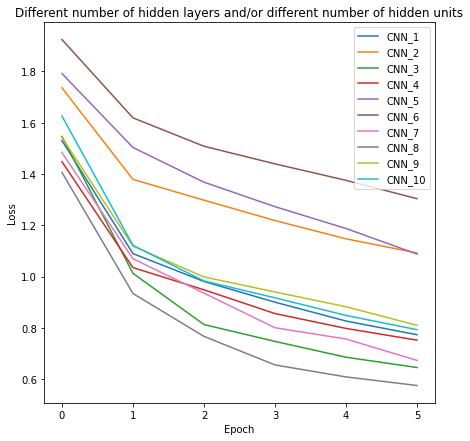

In [137]:
plt.figure(figsize=(7, 7))
plt.plot(CNN_1_history.history['loss'], label = 'CNN_1')
plt.plot(CNN_2_history.history['loss'], label = 'CNN_2')
plt.plot(CNN_3_history.history['loss'], label = 'CNN_3')
plt.plot(CNN_4_history.history['loss'], label = 'CNN_4')
plt.plot(CNN_5_history.history['loss'], label = 'CNN_5')
plt.plot(CNN_6_history.history['loss'], label = 'CNN_6')
plt.plot(CNN_7_history.history['loss'], label = 'CNN_7')
plt.plot(CNN_8_history.history['loss'], label = 'CNN_8')
plt.plot(CNN_9_history.history['loss'], label = 'CNN_9')
plt.plot(CNN_10_history.history['loss'], label = 'CNN_10')
plt.title('Different number of hidden layers and/or different number of hidden units')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### d. the training performance for at least three different optimization algorithms.

In [25]:
#RMSprop
CNN_model_rmsprop = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_rmsprop.summary()

#Complie
CNN_model_rmsprop.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_rmsprop_history = CNN_model_rmsprop.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_31 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 25s 145ms/step - loss: 2.5529 - sparse_categorical_accur

In [26]:
#Adadelta
CNN_model_Adadelta = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_Adadelta.summary()

#Complie
CNN_model_Adadelta.compile(
    optimizer = tf.keras.optimizers.Adadelta(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_adadelta_history = CNN_model_Adadelta.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_33 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 23s 135ms/step - loss: 2.2558 - sparse_categorical_accur

In [27]:
#Ftrl
CNN_model_Ftrl = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_Ftrl.summary()

#Complie
CNN_model_Ftrl.compile(
    optimizer = tf.keras.optimizers.Ftrl(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_Ftrl_history = CNN_model_Ftrl.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_35 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 22s 130ms/step - loss: 2.3024 - sparse_categorical_accur

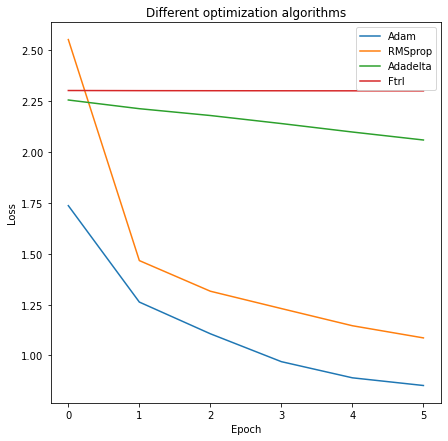

In [28]:
plt.figure(figsize=(7, 7))
plt.plot(CNN_0_history.history['loss'], label = 'Adam')
plt.plot(CNN_rmsprop_history.history['loss'], label = 'RMSprop')
plt.plot(CNN_adadelta_history.history['loss'], label = 'Adadelta')
plt.plot(CNN_Ftrl_history.history['loss'], label = 'Ftrl')

plt.title('Different optimization algorithms')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### e. the training performance for at least three different number of epochs.

In [29]:
#Epochs - 9
CNN_model_e9 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_e9.summary()

#Complie
CNN_model_e9.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_e9_history = CNN_model_e9.fit(ds_train, epochs=9, batch_size=256,verbose=1)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_37 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9
169/169 [==============================] - 22s 128ms/step - loss: 1.8744 - sparse_categorical_accur

In [30]:
#Epochs - 12
CNN_model_e12 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_e12.summary()

#Complie
CNN_model_e12.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_e12_history = CNN_model_e12.fit(ds_train, epochs=12, batch_size=256,verbose=1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_39 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
169/169 [==============================] - 55s 324ms/step - loss: 2.0251 - sparse_categorical_accu

In [31]:
#Epochs - 15
CNN_model_e15 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_e15.summary()

#Complie
CNN_model_e15.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_e15_history = CNN_model_e15.fit(ds_train, epochs=15, batch_size=256,verbose=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_41 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
169/169 [==============================] - 35s 203ms/step - loss: 1.6095 - sparse_categorical_accu

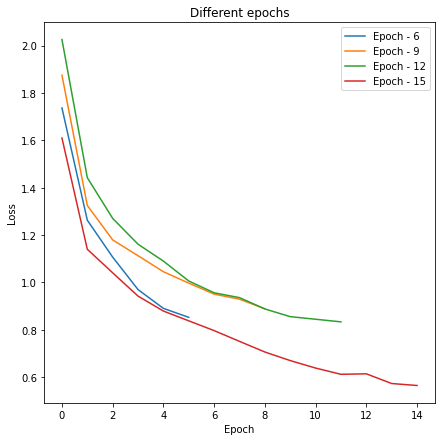

In [32]:
plt.figure(figsize=(7, 7))
plt.plot(CNN_0_history.history['loss'], label = 'Epoch - 6')
plt.plot(CNN_e9_history.history['loss'], label = 'Epoch - 9')
plt.plot(CNN_e12_history.history['loss'], label = 'Epoch - 12')
plt.plot(CNN_e15_history.history['loss'], label = 'Epoch - 15')

plt.title('Different epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### f. the training performance for at least three different weight initializations.

In [33]:
#random_uniform
CNN_model_ru = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu', kernel_initializer='random_uniform'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_ru.summary()

#Complie
CNN_model_ru.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_ru_history = CNN_model_ru.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_43 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 32s 187ms/step - loss: 2.0505 - sparse_categorical_accur

In [34]:
#he_uniform
CNN_model_he = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_he.summary()

#Complie
CNN_model_he.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_he_history = CNN_model_he.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_45 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 33s 193ms/step - loss: 1.4147 - sparse_categorical_accur

In [35]:
#lecun uniform
CNN_model_lu = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu', kernel_initializer='lecun_uniform'),
                    Dense(10, activation='softmax')
])
#Summary
CNN_model_lu.summary()

#Complie
CNN_model_lu.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
CNN_lu_history = CNN_model_lu.fit(ds_train, epochs=6, batch_size=256,verbose=1)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 28800)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                1843264   
_________________________________________________________________
dense_47 (Dense)             (None, 10)                650       
Total params: 1,844,138
Trainable params: 1,844,138
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
169/169 [==============================] - 35s 203ms/step - loss: 1.7436 - sparse_categorical_accur

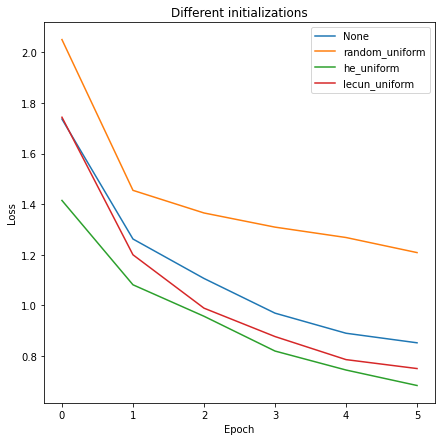

In [36]:
plt.figure(figsize=(7, 7))
plt.plot(CNN_0_history.history['loss'], label = 'None')
plt.plot(CNN_ru_history.history['loss'], label = 'random_uniform')
plt.plot(CNN_he_history.history['loss'], label = 'he_uniform')
plt.plot(CNN_lu_history.history['loss'], label = 'lecun_uniform')

plt.title('Different initializations')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### g. the best model fitting your training set

In [39]:
## Best model
# Model8 + Adam optimizer + 15 epochs + he_uniform weight initialization
Best_model = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dense(10, activation='softmax')
])
#Summary
Best_model.summary()

#Complie
Best_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
Best_model_history = Best_model.fit(ds_train, epochs=15, batch_size=256,verbose=1)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_52 (Dense)             (None, 64)              

## 2) Fit validation set

### a. How well is your model fitting the validation data

In [40]:
val_history = Best_model.fit(ds_val, epochs=15, batch_size=256,verbose=1)

Epoch 1/15
22/22 [==============================] - 7s 330ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.7589
Epoch 2/15
22/22 [==============================] - 7s 332ms/step - loss: 0.7881 - sparse_categorical_accuracy: 0.7156
Epoch 3/15
22/22 [==============================] - 8s 345ms/step - loss: 0.5785 - sparse_categorical_accuracy: 0.7833
Epoch 4/15
22/22 [==============================] - 8s 355ms/step - loss: 0.5501 - sparse_categorical_accuracy: 0.7956
Epoch 5/15
22/22 [==============================] - 8s 359ms/step - loss: 0.4805 - sparse_categorical_accuracy: 0.8181
Epoch 6/15
22/22 [==============================] - 8s 358ms/step - loss: 0.4566 - sparse_categorical_accuracy: 0.8296
Epoch 7/15
22/22 [==============================] - 8s 355ms/step - loss: 0.4216 - sparse_categorical_accuracy: 0.8474
Epoch 8/15
22/22 [==============================] - 8s 353ms/step - loss: 0.3964 - sparse_categorical_accuracy: 0.8659
Epoch 9/15
22/22 [==============================

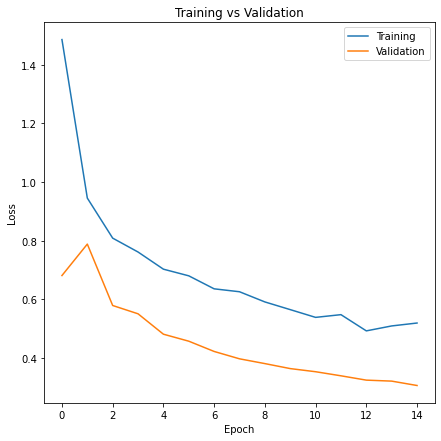

In [41]:
plt.figure(figsize=(7, 7))
plt.plot(Best_model_history.history['loss'], label = 'Training')
plt.plot(val_history.history['loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### b. the validation performance for five different penalty (λ) rates. 

In [42]:
## L2 regularization - 0.001
l2_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])
#Summary
l2_1.summary()

#Complie
l2_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_1_history = l2_1.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_55 (Dense)             (None, 64)              

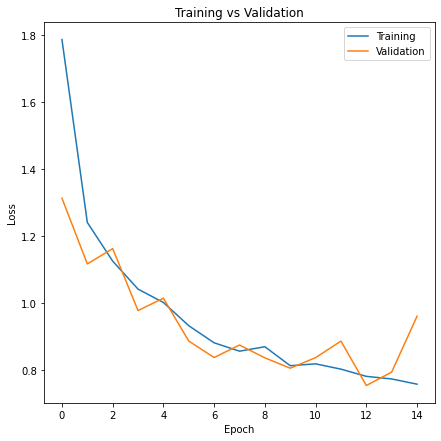

In [45]:
plt.figure(figsize=(7, 7))
plt.plot(l2_1_history.history['loss'], label = 'Training')
plt.plot(l2_1_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [46]:
## L2 regularization - 0.005
l2_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))
])
#Summary
l2_2.summary()

#Complie
l2_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_2_history = l2_2.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_58 (Dense)             (None, 64)              

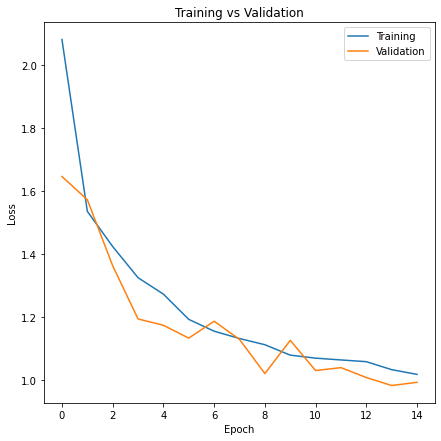

In [47]:
plt.figure(figsize=(7, 7))
plt.plot(l2_2_history.history['loss'], label = 'Training')
plt.plot(l2_2_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [48]:
## L2 regularization - 0.01
l2_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])
#Summary
l2_3.summary()

#Complie
l2_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_3_history = l2_3.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_61 (Dense)             (None, 64)              

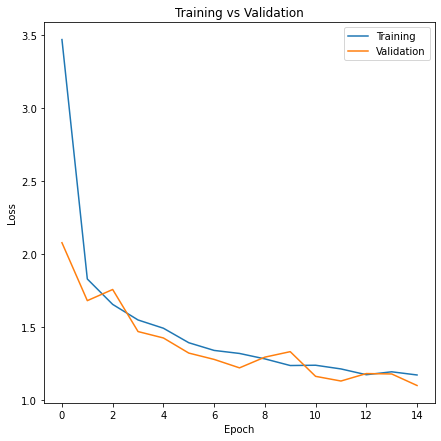

In [49]:
plt.figure(figsize=(7, 7))
plt.plot(l2_3_history.history['loss'], label = 'Training')
plt.plot(l2_3_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [50]:
## L2 regularization - 0.05
l2_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
                    Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.05))
])
#Summary
l2_4.summary()

#Complie
l2_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_4_history = l2_4.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_64 (Dense)             (None, 64)              

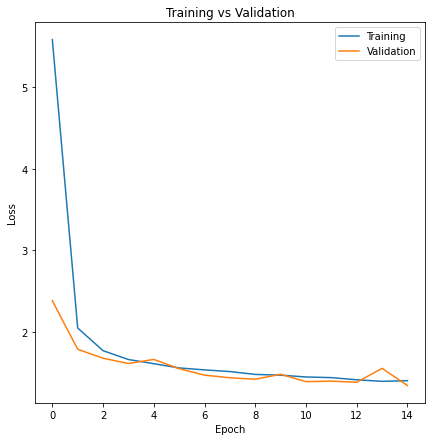

In [51]:
plt.figure(figsize=(7, 7))
plt.plot(l2_4_history.history['loss'], label = 'Training')
plt.plot(l2_4_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [52]:
## L2 regularization - 0.1
l2_5 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
                    Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])
#Summary
l2_5.summary()

#Complie
l2_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_5_history = l2_5.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_67 (Dense)             (None, 64)              

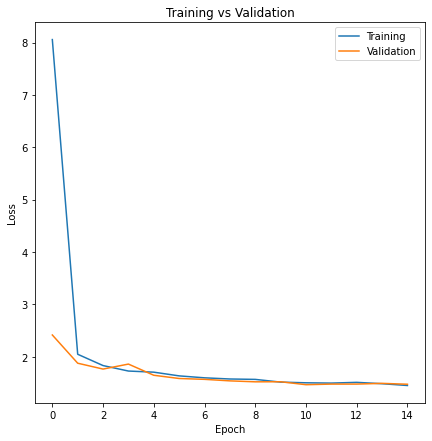

In [53]:
plt.figure(figsize=(7, 7))
plt.plot(l2_5_history.history['loss'], label = 'Training')
plt.plot(l2_5_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### c. the validation performance for five different dropout rates

In [54]:
## Dropout - 0.1
do_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.1),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.1),
                    Dense(10, activation='softmax')
])
#Summary
do_1.summary()

#Complie
do_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
do_1_history = do_1.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)             

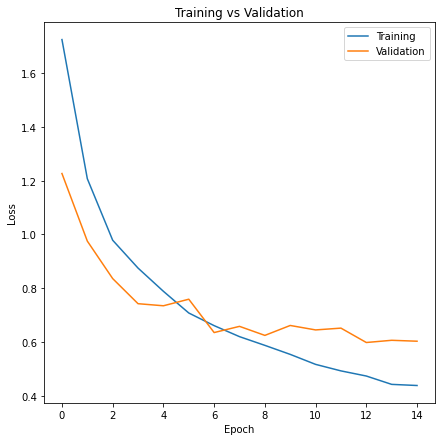

In [55]:
plt.figure(figsize=(7, 7))
plt.plot(do_1_history.history['loss'], label = 'Training')
plt.plot(do_1_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [56]:
## Dropout - 0.2
do_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.2),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.2),
                    Dense(10, activation='softmax')
])
#Summary
do_2.summary()

#Complie
do_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
do_2_history = do_2.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)             

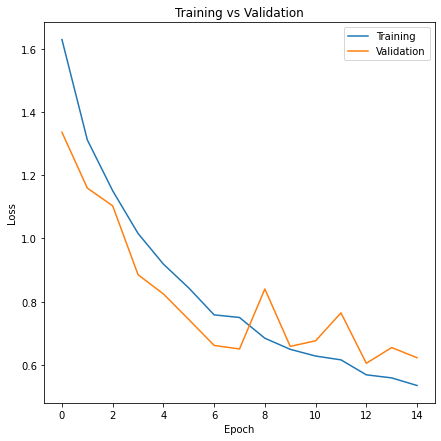

In [57]:
plt.figure(figsize=(7, 7))
plt.plot(do_2_history.history['loss'], label = 'Training')
plt.plot(do_2_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [58]:
## Dropout - 0.3
do_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
do_3.summary()

#Complie
do_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
do_3_history = do_3.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)             

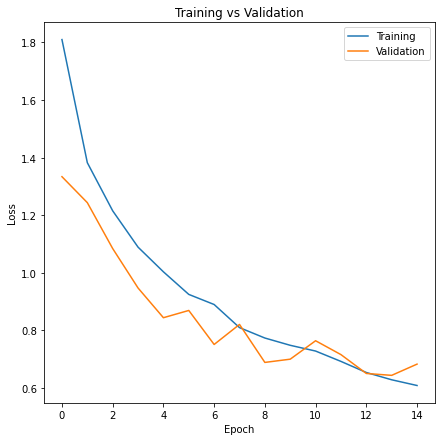

In [59]:
plt.figure(figsize=(7, 7))
plt.plot(do_3_history.history['loss'], label = 'Training')
plt.plot(do_3_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [60]:
## Dropout - 0.4
do_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
do_4.summary()

#Complie
do_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
do_4_history = do_4.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)             

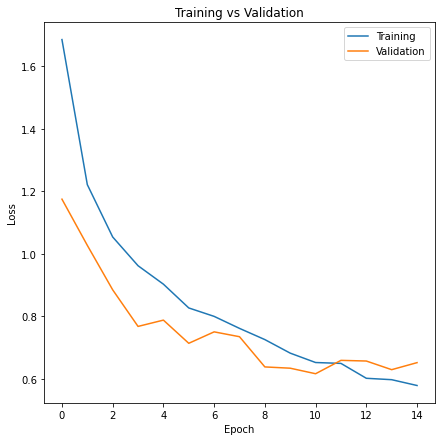

In [61]:
plt.figure(figsize=(7, 7))
plt.plot(do_4_history.history['loss'], label = 'Training')
plt.plot(do_4_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [62]:
## Dropout - 0.5
do_5 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.5),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    Dropout(0.5),
                    Dense(10, activation='softmax')
])
#Summary
do_5.summary()

#Complie
do_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
do_5_history = do_5.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_81 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)             

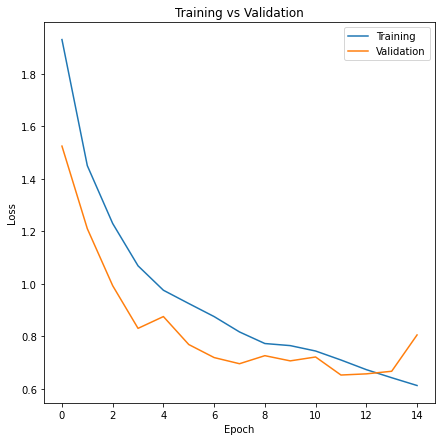

In [63]:
plt.figure(figsize=(7, 7))
plt.plot(do_5_history.history['loss'], label = 'Training')
plt.plot(do_5_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### d. the validation performance for five different combinations (L2 & drop out)

In [64]:
## combinations - 0.001(L2) & 0.3(Dropout)
l2_do_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
l2_do_1.summary()

#Complie
l2_do_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_do_1_history = l2_do_1.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_84 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)             

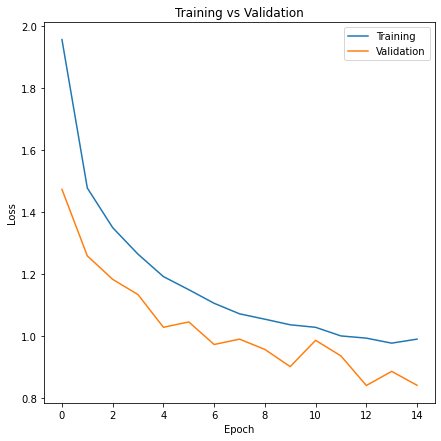

In [65]:
plt.figure(figsize=(7, 7))
plt.plot(l2_do_1_history.history['loss'], label = 'Training')
plt.plot(l2_do_1_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [66]:
## combinations - 0.001(L2) & 0.4(Dropout)
l2_do_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
l2_do_2.summary()

#Complie
l2_do_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_do_2_history = l2_do_2.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_87 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)             

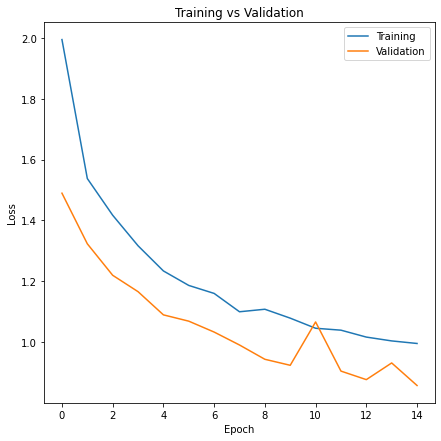

In [67]:
plt.figure(figsize=(7, 7))
plt.plot(l2_do_2_history.history['loss'], label = 'Training')
plt.plot(l2_do_2_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [68]:
## combinations - 0.01(L2) & 0.3(Dropout)
l2_do_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
l2_do_3.summary()

#Complie
l2_do_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_do_3_history = l2_do_3.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)             

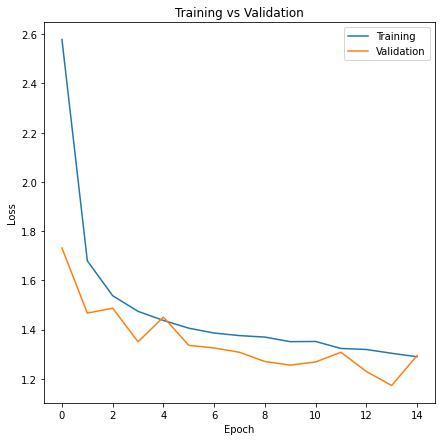

In [69]:
plt.figure(figsize=(7, 7))
plt.plot(l2_do_3_history.history['loss'], label = 'Training')
plt.plot(l2_do_3_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [70]:
## combinations - 0.01(L2) & 0.4(Dropout)
l2_do_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
l2_do_4.summary()

#Complie
l2_do_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_do_4_history = l2_do_4.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_93 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)             

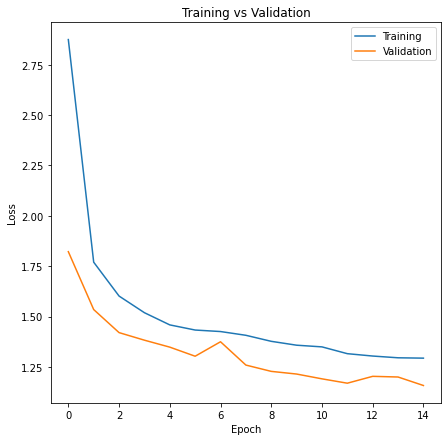

In [71]:
plt.figure(figsize=(7, 7))
plt.plot(l2_do_4_history.history['loss'], label = 'Training')
plt.plot(l2_do_4_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [72]:
## combinations - 0.005(L2) & 0.3(Dropout)
l2_do_5 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
l2_do_5.summary()

#Complie
l2_do_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_do_5_history = l2_do_5.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_96 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)             

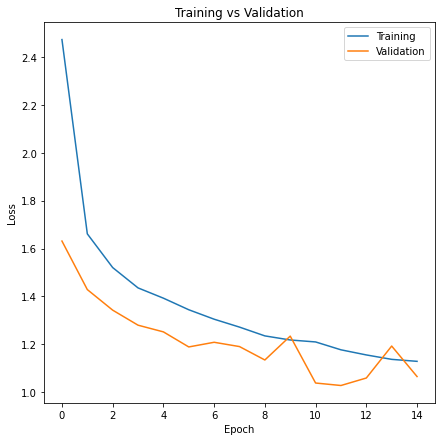

In [73]:
plt.figure(figsize=(7, 7))
plt.plot(l2_do_5_history.history['loss'], label = 'Training')
plt.plot(l2_do_5_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [74]:
## combinations - 0.005(L2) & 0.4(Dropout)
l2_do_6 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
l2_do_6.summary()

#Complie
l2_do_6.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
l2_do_6_history = l2_do_6.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_99 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)             

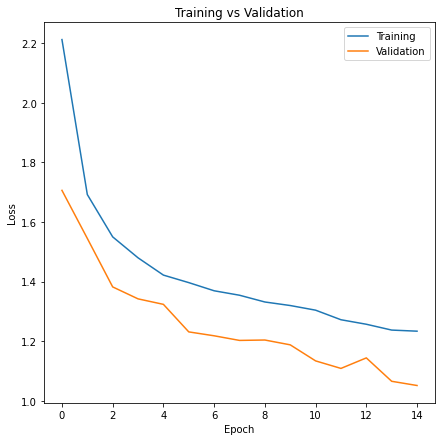

In [75]:
plt.figure(figsize=(7, 7))
plt.plot(l2_do_6_history.history['loss'], label = 'Training')
plt.plot(l2_do_6_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### e. the validation performance for five different batch-normalizations

In [97]:
## batch-normalization - Default
batch_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dense(10, activation='softmax')
])
#Summary
batch_1.summary()

#Complie
batch_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_1_history = batch_1.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_135 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)             

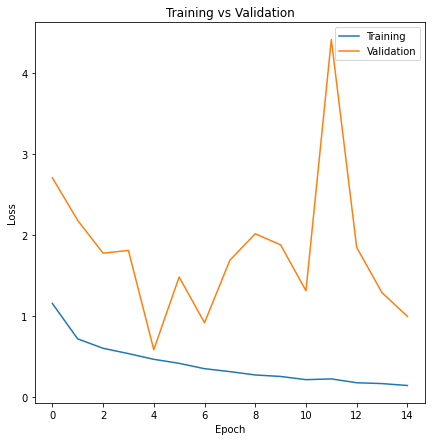

In [98]:
plt.figure(figsize=(7, 7))
plt.plot(batch_1_history.history['loss'], label = 'Training')
plt.plot(batch_1_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [99]:
## batch-normalization - epsilon=0.005
batch_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.005),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.005),
                    Dense(10, activation='softmax')
])
#Summary
batch_2.summary()

#Complie
batch_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_2_history = batch_2.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_138 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_24 (Batc (None, 256)             

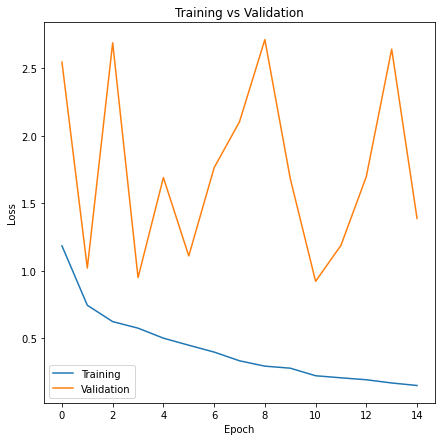

In [100]:
plt.figure(figsize=(7, 7))
plt.plot(batch_2_history.history['loss'], label = 'Training')
plt.plot(batch_2_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [101]:
## batch-normalization - momentum=0.95
batch_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(momentum=0.95),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(momentum=0.95),
                    Dense(10, activation='softmax')
])
#Summary
batch_3.summary()

#Complie
batch_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_3_history = batch_3.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_141 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)             

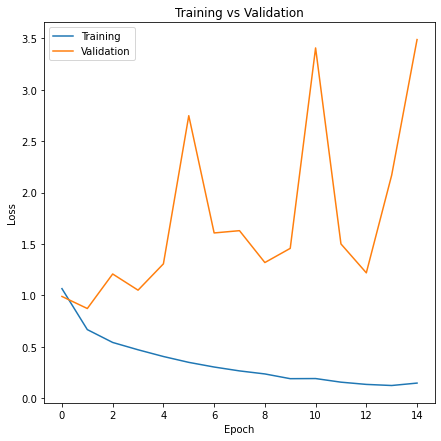

In [102]:
plt.figure(figsize=(7, 7))
plt.plot(batch_3_history.history['loss'], label = 'Training')
plt.plot(batch_3_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [103]:
## batch-normalization - epsilon=0.005, momentum=0.95
batch_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.005, momentum=0.95),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.005, momentum=0.95),
                    Dense(10, activation='softmax')
])
#Summary
batch_4.summary()

#Complie
batch_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_4_history = batch_4.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_144 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)             

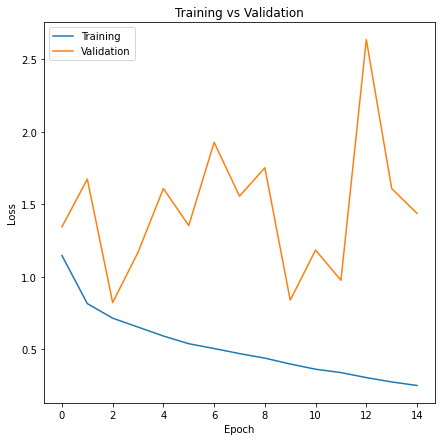

In [104]:
plt.figure(figsize=(7, 7))
plt.plot(batch_4_history.history['loss'], label = 'Training')
plt.plot(batch_4_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [105]:
## batch-normalization - epsilon=0.01
batch_5 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.01),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.01),
                    Dense(10, activation='softmax')
])
#Summary
batch_5.summary()

#Complie
batch_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_5_history = batch_5.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_147 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)             

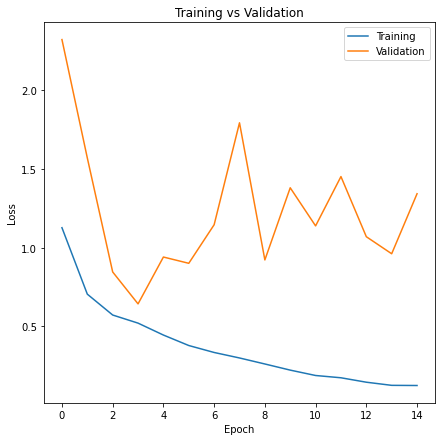

In [106]:
plt.figure(figsize=(7, 7))
plt.plot(batch_5_history.history['loss'], label = 'Training')
plt.plot(batch_5_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### f. the validation performance for five different combinations (batch-normalizations & drop out)

In [108]:
## batch-normalization&drop out - default, dropout=0.3
batch_do_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
batch_do_1.summary()

#Complie
batch_do_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_do_1_history = batch_do_1.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_150 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)             

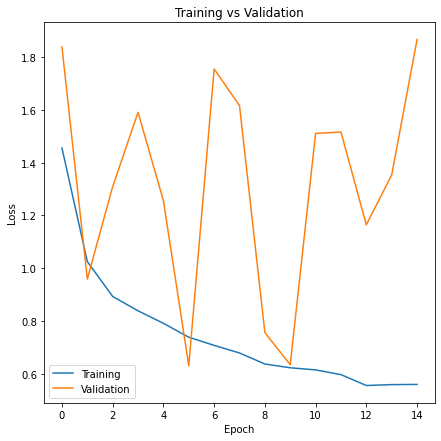

In [109]:
plt.figure(figsize=(7, 7))
plt.plot(batch_do_1_history.history['loss'], label = 'Training')
plt.plot(batch_do_1_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [110]:
## batch-normalization&drop out - epsilon=0.01, dropout=0.3
batch_do_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.01),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.01),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
batch_do_2.summary()

#Complie
batch_do_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_do_2_history = batch_do_2.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_153 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)             

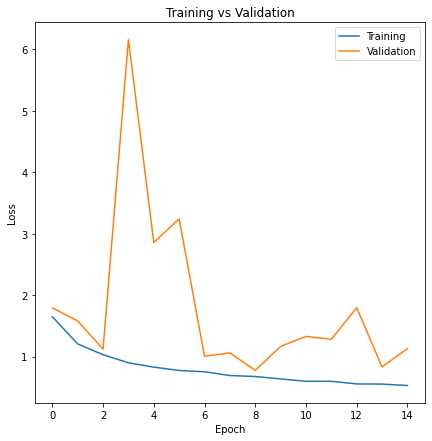

In [111]:
plt.figure(figsize=(7, 7))
plt.plot(batch_do_2_history.history['loss'], label = 'Training')
plt.plot(batch_do_2_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [112]:
## batch-normalization&drop out - epsilon=0.005, dropout=0.3
batch_do_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.005),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon=0.005),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
batch_do_3.summary()

#Complie
batch_do_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_do_3_history = batch_do_3.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_156 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_36 (Batc (None, 256)             

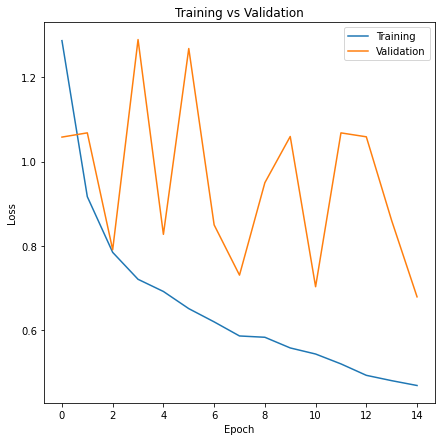

In [113]:
plt.figure(figsize=(7, 7))
plt.plot(batch_do_3_history.history['loss'], label = 'Training')
plt.plot(batch_do_3_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [114]:
## batch-normalization&drop out - default, dropout=0.4
batch_do_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
batch_do_4.summary()

#Complie
batch_do_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_do_4_history = batch_do_4.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_159 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_38 (Batc (None, 256)             

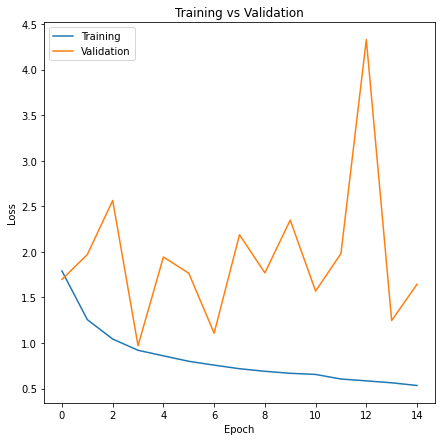

In [115]:
plt.figure(figsize=(7, 7))
plt.plot(batch_do_4_history.history['loss'], label = 'Training')
plt.plot(batch_do_4_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [138]:
## batch-normalization&drop out - epsilon= 0.01, dropout=0.4
batch_do_5 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform'),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
batch_do_5.summary()

#Complie
batch_do_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
batch_do_5_history = batch_do_5.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_113 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_182 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_52 (Batc (None, 256)             

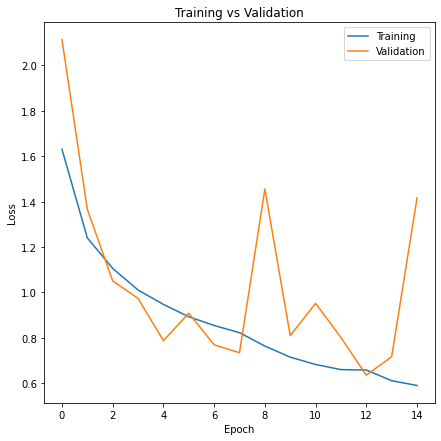

In [139]:
plt.figure(figsize=(7, 7))
plt.plot(batch_do_5_history.history['loss'], label = 'Training')
plt.plot(batch_do_5_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### g. the validation performance for five different combinations (batch-normalizations & dropout & L2)

In [118]:
## batch-normalization&drop out&L2 - batch(epsilon= 0.01), dropout=0.3, L2=0.01
all_1 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
all_1.summary()

#Complie
all_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
all_1_history = all_1.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_165 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_42 (Batc (None, 256)             

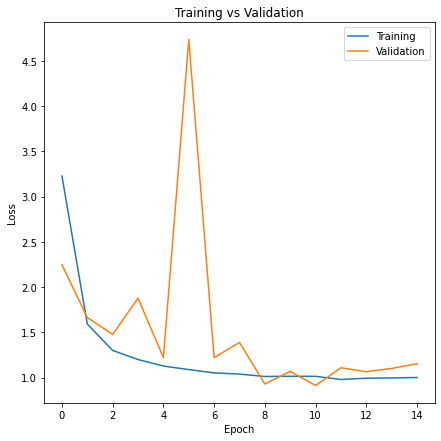

In [119]:
plt.figure(figsize=(7, 7))
plt.plot(all_1_history.history['loss'], label = 'Training')
plt.plot(all_1_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [120]:
## batch-normalization&drop out&L2 - batch(epsilon= 0.005), dropout=0.3, L2=0.01
all_2 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    BatchNormalization(epsilon= 0.005),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    BatchNormalization(epsilon= 0.005),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
all_2.summary()

#Complie
all_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
all_2_history = all_2.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_168 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_44 (Batc (None, 256)             

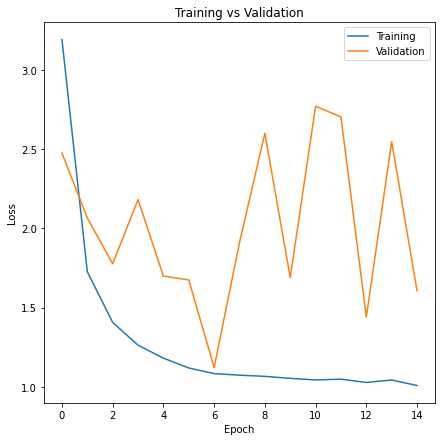

In [121]:
plt.figure(figsize=(7, 7))
plt.plot(all_2_history.history['loss'], label = 'Training')
plt.plot(all_2_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [122]:
## batch-normalization&drop out&L2 - batch(epsilon= 0.01), dropout=0.3, L2=0.005
all_3 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.3),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.3),
                    Dense(10, activation='softmax')
])
#Summary
all_3.summary()

#Complie
all_3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
all_3_history = all_3.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_171 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)             

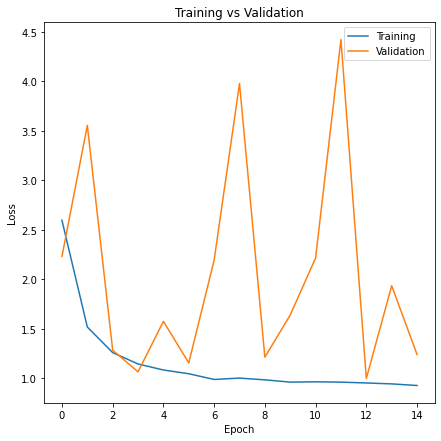

In [123]:
plt.figure(figsize=(7, 7))
plt.plot(all_3_history.history['loss'], label = 'Training')
plt.plot(all_3_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [124]:
## batch-normalization&drop out&L2 - batch(epsilon= 0.01), dropout=0.4, L2=0.01
all_4 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
all_4.summary()

#Complie
all_4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
all_4_history = all_4.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_62 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_174 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_48 (Batc (None, 256)             

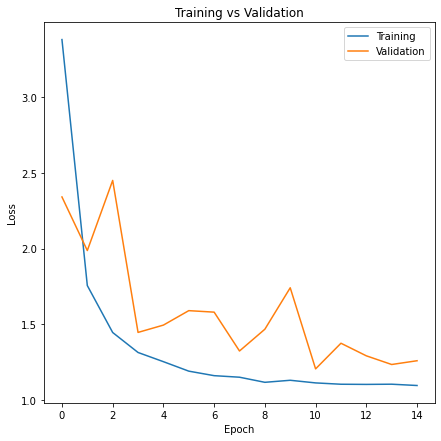

In [125]:
plt.figure(figsize=(7, 7))
plt.plot(all_4_history.history['loss'], label = 'Training')
plt.plot(all_4_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [126]:
## batch-normalization&drop out&L2 - batch(epsilon= 0.01), dropout=0.4, L2=0.005
all_5 = Sequential([
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu', input_shape=(64,64,3)),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='valid'),
                    Flatten(),
                    Dense(256, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.4),
                    Dense(64, activation = 'relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                    BatchNormalization(epsilon= 0.01),
                    Dropout(0.4),
                    Dense(10, activation='softmax')
])
#Summary
all_5.summary()

#Complie
all_5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
all_5_history = all_5.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1)

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 60, 60, 8)         0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 58, 58, 8)         584       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 56, 56, 8)         0         
_________________________________________________________________
flatten_63 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_177 (Dense)            (None, 256)               6422784   
_________________________________________________________________
batch_normalization_50 (Batc (None, 256)             

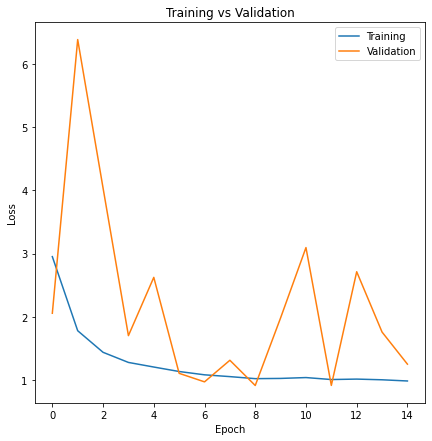

In [127]:
plt.figure(figsize=(7, 7))
plt.plot(all_5_history.history['loss'], label = 'Training')
plt.plot(all_5_history.history['val_loss'], label = 'Validation')


plt.title('Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### h. the best model fitting your validations set

In [129]:
#ModelCheckpoint callback
checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                             save_freq='epoch',
                             save_weights_only=True,
                             monitor='val_sparse_categorical_accuracy',
                             save_best_only=True,
                             verbose=1)

In [135]:
# The model, which has 0.3 of dropout, is the best model fitting for validation set
final_model = do_3

#Complie
final_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
)

#Fit
final_model_history = final_model.fit(ds_train, epochs=15, batch_size=256, validation_data=ds_val, verbose=1, callbacks = [checkpoint_best])

Epoch 1/15
169/169 [==============================] - 65s 383ms/step - loss: 0.5475 - sparse_categorical_accuracy: 0.8031 - val_loss: 0.7129 - val_sparse_categorical_accuracy: 0.7619

Epoch 00001: val_sparse_categorical_accuracy did not improve from 0.79185
Epoch 2/15
169/169 [==============================] - 69s 410ms/step - loss: 0.4833 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.6804 - val_sparse_categorical_accuracy: 0.7656

Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.79185
Epoch 3/15
169/169 [==============================] - 72s 424ms/step - loss: 0.4725 - sparse_categorical_accuracy: 0.8322 - val_loss: 0.6801 - val_sparse_categorical_accuracy: 0.7763

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.79185
Epoch 4/15
169/169 [==============================] - 69s 406ms/step - loss: 0.4505 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.7046 - val_sparse_categorical_accuracy: 0.7693

Epoch 00004: val_sparse_categorical_accura

## 3) Best model

### Compare the training performance, validation performance and test performance

In [140]:
#Training performance
final_model.load_weights(checkpoint_best_path)
final_train_loss, final_train_accuracy = final_model.evaluate(ds_train)
print(f"Accuracy:{final_train_accuracy}")
print(f"Loss:{final_train_loss}")

169/169 [==============================] - 14s 85ms/step - loss: 0.3255 - sparse_categorical_accuracy: 0.8883
Accuracy:0.8882870078086853
Loss:0.3254767060279846


In [141]:
#Validation performance
final_model.load_weights(checkpoint_best_path)
final_val_loss, final_val_accuracy = final_model.evaluate(ds_val)
print(f"Accuracy:{final_val_accuracy}")
print(f"Loss:{final_val_loss}")

22/22 [==============================] - 2s 72ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7919
Accuracy:0.7918518781661987
Loss:0.6337648630142212


In [142]:
#test performance
final_model.load_weights(checkpoint_best_path)
final_test_loss, final_test_accuracy = final_model.evaluate(ds_test)
print(f"Accuracy:{final_test_accuracy}")
print(f"Loss:{final_test_loss}")

22/22 [==============================] - 2s 74ms/step - loss: 0.6596 - sparse_categorical_accuracy: 0.7807
Accuracy:0.7807407379150391
Loss:0.6596003770828247
